# Introduction
Founded in 1997, MovieLens is a website and online community that generates movie recommendations for users via collaborative filtering.  Users begin by creating an account and rating some number of movies they have previously watched on a scale of 0.5 stars to 5 stars. MovieLens's recommendation algorithm then uses the user's ratings, as well as other users' rating patterns, to generate movie recommendations for the user. As the user rates more movies over time, the recommendations change in real time, becoming more personalized (and thus theoretically more successful) over time.

MovieLens makes its datasets, consisting of some 20 million ratings covering over 27,000 movies, available to the public.  These datasets include the numerical rating and the associated user ID, movie ID, and date and time of rating.  For this study, we'll look at two datasets: a up-to-date random sample of 100K ratings, and a full dataset of 20 million ratings.  For ease of use, we'll begin with an exploratory look at the smaller 100K sample.  Later on, we'll run significance tests and use the larger dataset as necessary. 

# Loading the Data

The function load_and_clean imports the specified datasets, reformats dates, and merges the ratings data with the movies data.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [2]:
# load small data
from load_and_clean import load_and_clean
smallRatings_df = load_and_clean("ml-latest-small/movies.csv", "ml-latest-small/ratings.csv")
smallRatings_df.head()

,userId,movieId,rating,title,genres,datetime,date,month,weekday
0,1,31,2.5,Dangerous Minds (1995),Drama,2009-12-14 02:52:24,2009-12-14,12,0
1,7,31,3.0,Dangerous Minds (1995),Drama,1996-12-29 14:12:30,1996-12-29,12,6
2,31,31,4.0,Dangerous Minds (1995),Drama,2010-05-11 01:39:13,2010-05-11,5,1
3,32,31,4.0,Dangerous Minds (1995),Drama,1996-06-15 08:47:20,1996-06-15,6,5
4,36,31,3.0,Dangerous Minds (1995),Drama,1996-11-03 21:40:02,1996-11-03,11,6


# Exploring the Data

The rating scores in this dataset have a left-skewed distribution across the range of ten possible values.  The mean rating is 3.5, with a standard deviation of about 1, and the most common rating is a 4.  Although the site allows half-star ratings (0.5, 1.5, etc), users give whole-star ratings (1.0, 2.0, etc) much more often.

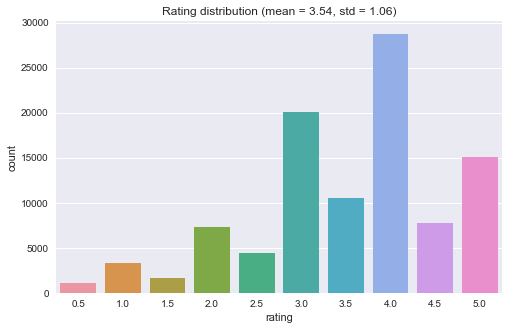

In [8]:
plt.figure(figsize=(8,5))
sns.countplot("rating", data=smallRatings_df)
rating_mean = smallRatings_df["rating"].mean()
rating_std = smallRatings_df["rating"].std()
plt.title("Rating distribution (mean = {}, std = {})".format(round(rating_mean, 2), round(rating_std, 2)))
plt.show()

Examining the times at which the ratings are given, we can see that the dataset begins at the smalles

# Question
One difficulty in assessing the ratings in this dataset is that participants give ratings at different time intervals from their actual viewing.  Some ratings represent ratings for a movie that the user watched just an hour beforehand and remembers in great detail, while others represent ratings for movies that the user watched many years beforehand and retains only a vague impression of.  Given the effects of memory over time, shifts in taste, and intervening life experiences, these ratings may be measuring very different attributes of the viewer-movie interaction.  Interpreting them as equivalent may lead to faulty conclusions and miss valuable insights.

We can roughly encapsulate these considerations in a single question: how do users' ratings of recently watched movies (say, within the past week) differ from their ratings of movies they watched long ago?

# Hypothesis
My hypothesis is that ratings not given recently after watching a movie will tend to regress to the average in users' minds, leading to a smaller degree of dispersion among ratings.  Concretely, my hypothesis is that the standard distribution will be lower for movies not rated recently after watching than for movies rated recently.

It will also be interesting to examine the mean. My secondary hypothesis is that the mean rating will be slightly lower for movies not rated recently after watching than for movies rated recently.

# Methodology
On the face of it, it seems difficult to answer this question based on the available data.  Because MovieLens does not ask the user how long ago or on what date they watched the movie (rating a movie is a one-click process), we don't have any direct time interval data.  However, we can make some inferences based on usage patterns.  Broadly, we can posit three typical usage patterns for rating movies:
<ol>
    <li><b>Profile-building visit:</b> the user rates multiple movies she has watched at some point - not necessarily recently - in order to generate initial recommendations. (Includes the initial site visit.)</li>
    <li><b>Targeted rating visit:</b> the user logs in specifically to rate one or more movies she has recently watched</li>
    <li><b>Hybrid rating visit:</b> the user logs in specifically to rate one or more movies she has recently watched, and then also rates one or more non-recently-watched movies while online.</li>
</ol>
Notably, none of these typical patterns include going online just to rate a single movie that the user watched long ago - it's hard to imagine what motive would prompt that behavior.  This is crucial, because it means that we can distinguish recent vs non-recent ratings based on how many movies the user rated that day.  Specifically, for the purposes of answering our question, we will divide the data into three groups:
<ul>
    <li><b>Singleton ratings:</b> ratings given on days on which that user recorded no other ratings</li>
    <li><b>Pair ratings:</b> ratings given on days on which that user recorded exactly one other rating</li>
    <li><b>Batch ratings:</b> ratings given on days on which that user recorded multiple other ratings</li>
</ul>

We will discard the pair ratings as ambiguous, since these could plausibly represent two recently watched movies (usage pattern 2), or one recently watched movie and one long-ago-watched movie the user saw in the recommendation section and also rated (usage pattern 3), or even two non-recently-watched movies rated on a profile-building visit to the site (usage pattern 1). We will compare the singleton ratings, which almost exclusively represent recently watched movies, against the batch ratings, which predominantly represent movies watched less recently than one week.

For each of these sets – the singleton ratings and the batch ratings – we will take the mean and the standard deviation.  As they are on the same scale, we do not need to normalize.  We will compare these metrics and run either z-tests or z-tests, depending on the size of these sets, to determine whether these differences are significant, defined as a p value of less than 5%.

Given the large size of the dataset (20 million ratings), it would make good pragmatic sense to begin with evaluating a smaller random subset of 100,000 ratings, which we will divide into singleton, pair, and batch ratings.  If the p values produced from these subsets are close to or greater than 5%, we will run the tests again on the entire dataset.

# Conclusions and success
This test will be successful if it demonstrates a significant difference between the singleton and batch rating datasets – in either direction.  Even if that difference is the opposite of the hypothesized difference, the test will have produced interesting and useful information about the dataset. The lower the p-value of the difference is, the more significant the result is.  Knowing the nature of this difference will allow us to take recency of rating into account as we analyze the dataset for other purposes.

On the other hand, if there are no significant differences between the two rating sets, this means that one of the premises of the experiment was misguided: either the singletons vs batch ratings do not predominantly represent recent vs non-recent ratings (respectively) as supposed, or recent vs non-recent ratings do not actually display any statistically significant differences.


# Further research
This statistical experiment will give us some basic data on how recent and non-recent ratings differ.  However, if we want further insight into the differences between these two types of ratings, we may want to design a survey instrument to distribute to a subset of MovieLens users.  Specifically, we might ask...

# Bonus: basic execution
